# Efficient quantum algorithm for dissipative nonlinear differential equations

Original authors of paper and code (MATLAB): Jin-Peng Liu, Herman Øie Kolden, Hari K. Krovi, Nuno F. Loureiro, Konstantina Trivisa, Andrew M. Childs.

Link to paper: https://www.pnas.org/doi/full/10.1073/pnas.2026805118

Pre-print: https://arxiv.org/abs/2011.03185 has official MATLAB code to reproduce results from the paper in https://github.com/hermankolden/CarlemanBurgers

Author of notebook: Óscar Amaro (2023)

In this notebook we convert the code into Python. Data labeled _WPD_ was taken from the figures of the paper with the tool [WebPlotDigitizer](https://apps.automeris.io/wpd/). All other data presented are results from this notebook.

For __MATLAB__ users wanting to use __Python__: https://numpy.org/doc/stable/user/numpy-for-matlab-users.html

__Python documentation__:
- Sparse matrices: https://docs.scipy.org/doc/scipy/reference/sparse.html
- Kronecker product: https://numpy.org/doc/stable/reference/generated/numpy.kron.html
- ODE solver: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
- PDE solver: https://py-pde.readthedocs.io/en/latest/

> To use py-pde, ```pip install pde h5py pandas pyfftw tqdm```

In [1]:
import numpy as np
from numpy import exp, log, sqrt, cos, sin, pi
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy import interpolate
from scipy.integrate import solve_ivp
from tqdm import tqdm, trange
import json
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph

In [156]:
# Takes the Kronecker power of a matrix
def kronp(A,k):
    B = 1;
    for i in range(k):
        B = np.kron(B, A);
    return B

# Simulation parameters
nx = 16; # Spatial discretization for Euler's method
nt = 4000; # Temporal discretization for Euler's method
nx_pde = 100; # Spatial discretization for the pdepe solver
nt_pde = 8000; # Temporal discretization for the pdepe solver, originally 40000

Re0 = 20; # Desired Reynolds number
L0 = 1; # Domain length
U0 = 1/sqrt(nx-1); # Initial maximum velocity
beta = 0; # Linear damping coefficient
f = 1; # Number of oscillations of the sinusoidal initial condition inside the domain
T = 3; # Simulation time

# driver source
def F0_fun(t,x): return U0*exp(-(x-L0/4)**2/(2*(L0/32)**2)) * cos(2*pi*t); # Source function.

N_max = 3; # Maximum Carleman truncation level
ode_deg = 2; # Degree of the Carleman ODE, should not be changed

# Initialize
Ns = np.arange(1,N_max+1,1); # Truncation levels

nu = U0*L0/Re0; # Viscosity
Tnl = L0/U0; # Nonlinear time
t_plot = Tnl/3; # Time to plot solution

# Spatial domain edges
x0 = -L0/2;
x1 = L0/2;

# Temporal domain edges
t0 = 0;
t1 = T;

# Euler's method discretization interval sizes and domains
dx = (x1-x0)/(nx-1);
dt = (t1-t0)/(nt-1);
xs = np.linspace(x0,x1,nx);
ts = np.linspace(t0,t1,nt);

# ode45 discretization
nt_ode = nt*10; # Make it more accurate than the Euler solution
dt_ode = (t1-t0)/(nt_ode-1);
ts_ode = np.linspace(t0,t1,nt_ode);

# pdepe discretization interval sizes
dx_pde = (x1-x0)/(nx_pde-1); # Spatial discretization interval size for pdepe solver
dt_pde = (t1-t0)/(nt_pde-1);
xs_pde = np.linspace(x0,x1,nx_pde);
ts_pde = np.linspace(t0,t1,nt_pde);

# Discretize Burger's equation
F0 = np.zeros((nt,nx));
for it in range(nt):
    F0[it,:] = F0_fun(ts[it],xs);

# F1
F1 = np.zeros((nx,nx)); #F1 = np.zeros((nx,nx));
for i in range(nx):
    if i>0:
        F1[i,i-1] = nu/dx**2;
    if i<nx-1:
        F1[i,i+1] = nu/dx**2;
    F1[i,i] = -2*nu/dx**2;
F1 = F1 - beta*np.identity(nx); # Add linear damping if present

# F2
F2 = np.zeros(nx**3);
F2[(nx**2+nx):-1:(nx**2+nx+1)] = -1/(4*dx);
F2[1:-1:(nx**2+nx+1)] = +1/(4*dx);
F2 = np.reshape(F2,(nx**2,nx)); # np.sum(F2 != 0) = 256 for nx=16
F2 = F2.transpose()
# Enforce the Dirichlet boundaries within the domain.
# F0(1) = 0;
# F0(end) = 0;

F1[0,:] = 0;
F1[-1,:] = 0;
F2[0,:] = 0;
F2[-1,:] = 0;

# Initial condition
def u0(x): return -U0*sin(2*pi*f*x/L0);
u0s = u0(xs);

In [157]:
# ODE for ode45 solver
#F0_interp_aux = interpolate.interp1d(ts,F0);
#def F0_interp(t):
#    return F0_interp_aux(ts,F0,t)
def burgers_odefun(t,u):
    return F0_fun(t,xs) + np.matmul(F1,u) + np.matmul(F2,np.kron(u,u));

# PDE, initial condition and boundary condition for pdepe solver
def burger_pde(x,t,u,dudx): return 1, nu*dudx-u**2/2, -beta*u + F0_fun(t,x);
burger_ic = u0;
def burger_bc(xl, ul, xr, ur, t): return ul, 0, ur, 0;

# Check CFL condition

# Dissipative and advective CFL numbers for Euler's method and pdepe
C1_e = U0*dt/dx;
C2_e = 2*nu*dt/dx**2;
C1_ode = U0*dt_ode/dx;
C2_ode = 2*nu*dt_ode/dx**2;
C1_pde = U0*dt_pde/dx_pde;
C2_pde = 2*nu*dt_pde/dx_pde**2;
if C1_e > 1:
    error(sprintf("C1_e = %.2f\n",C1_e));
if C2_e > 1:
    error(sprintf("C2_e = %.2f\n",C2_e));
if C1_ode > 1:
    error(sprintf("C1_ode = %.2f\n",C1_ode));
if C2_ode > 1:
    error(sprintf("C2_ode = %.2f\n",C2_ode));
if C1_pde > 1:
    error(sprintf("C1_pde = %.2f\n",C1_pde));
if C2_pde > 1:
    error(sprintf("C2_pde = %.2f\n",C2_pde));

# Calculate the Carleman convergence number
lambdas, _ = LA.eig(F1);
#print(lambdas)
lambdas = lambdas[lambdas != 0];
lbd = np.max(lambdas);

f2 = LA.norm(F2);
f1 = LA.norm(F1);
f0 = 0.0;
for it in range(nt):
    f0 = np.max([LA.norm(F0[it,:]),f0]);
R = (LA.norm(u0s)*f2+f0/LA.norm(u0s))/np.abs(lbd);

#r1 = (np.abs(lbd)-sqrt(lbd**2-4*f2*f0))/(2*f2); # these values are not used
#r2 = (np.abs(lbd)+sqrt(lbd**2-4*f2*f0))/(2*f2); #

if dt > 1/(N_max*f1):
    print('Time step too large'); exit();

if f0 + f2 > np.abs(lbd):
    print('Perturbation too large\n');

Perturbation too large



In [148]:
# Solve direct Euler
print('Solving direct Euler\n');
us_e = np.zeros((nt,nx));
us_e[0,:] = u0s;
#
for k in trange(nt-1):
    us_e[k+1,:] = us_e[k,:] + dt*burgers_odefun(ts[k],us_e[k,:]);
    
# Solve "exact" ODE
print('Solving "exact" ODE\n');
# scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
sol = solve_ivp(fun=burgers_odefun, t_span=[0, np.max(ts_ode)], y0=u0s, method='RK45', rtol=1e-10, atol=1e-10)
ts_ode, us_ode = sol.t, sol.y
#
# Interpolate so we can compare with other solutions
us_d_aux = interpolate.interp1d(ts_ode,us_ode);
us_d = us_d_aux(ts);

Solving direct Euler



100%|█████████████████████████████████████| 3999/3999 [00:00<00:00, 9647.49it/s]


Solving "exact" ODE



In [149]:
print('Solving "exact" PDE\n');
class BurgersPDE(PDEBase):
    """py-pde Burger's equation"""
    def evolution_rate(self, state, t=0):
        """implement the python version of the evolution equation"""
        assert state.grid.dim == 1  # ensure the state is one-dimensional
        u = state
        grad_x = state.gradient("auto_periodic_neumann")[0]
        return -u*grad_x + nu*u.laplace("auto_periodic_neumann") + F0_fun(t,xs_pde) #"auto_periodic_neumann"

# initialize the equation and the space
grid = CartesianGrid([[-0.5, 0.5]], [len(xs_pde)], periodic=True)
state = ScalarField.from_expression(grid, "-{}*sin(2*pi*x)".format(U0))

# solve the equation and store the trajectory
eq = BurgersPDE()

storage = MemoryStorage()
eq.solve(state, t_range=T, dt=(T/(len(ts_pde)-1)), tracker=[storage.tracker((T/(len(ts_pde)-1)))])
#plot_kymograph(storage)
us_pde = np.array(storage.data)

# Interpolate so we can compare with other solutions.
# First interpolate over space, and then over time.
us_pde_interp_temp = np.zeros((nt,nx_pde));
for i in trange(nx_pde):
    intaux = interpolate.interp1d(ts_pde,us_pde[:,i]);
    us_pde_interp_temp[:,i] = intaux(ts)
#
us_pde_interp = np.zeros((nt,nx));
for k in trange(nt):
    intaux = interpolate.interp1d(xs_pde,us_pde_interp_temp[k,:]);
    us_pde_interp[k,:] = intaux(xs)

Solving "exact" PDE



100%|█████████████████████████████████████| 4000/4000 [00:00<00:00, 9139.55it/s]


In [158]:
# Prepare Carleman matrix
print('Preparing Carleman matrix\n');

# Calculate matrix block sizes
dNs = np.zeros(N_max, dtype=np.int64);
for N in Ns:
    dNs[N-1] = (nx**(N+1)-nx)/(nx-1) ;
    
# First prepare the Carleman system with just the source term at t=0
#A = spalloc(dNs[-1],dNs[-1],dNs[-1]*nx);
A = csr_matrix((int(dNs[-1]), int(dNs[-1])))
A = A.todense()
Fs = np.zeros( (nx,1 + np.shape(F1)[1] + np.shape(F2)[1]) ) # Fs = [F0_fun(0,xs), F1, F2];
Fs[:, 0] = F0_fun(0,xs); Fs[:, 1:np.shape(F1)[1]+1] = F1; Fs[:, np.shape(F1)[1]+1:] = F2
for i in Ns:
    for j in range(0, np.min([ode_deg,N_max-i+1])+1 ):
        if (i != 1) or (j != 0):
            a0 = int( (nx**(i) - nx)/(nx-1) );
            a1 = int( a0 + nx**i );
            b0 = int( (nx**(j+i-1)-nx)/(nx-1) );
            b1 = int( b0 + nx**(j+i-1) );

            Aij = np.zeros( (nx**i,nx**(i+j-1)) );
            f0 = int( (nx**j-nx)/(nx-1)+1 );
            f1 = f0+nx**j;
            Fj = Fs[:,f0:f1];
            for p in range(1,i+1):
                Ia = kronp( np.identity(nx), p-1);
                Ib = kronp( np.identity(nx), i-p);
                Aij = Aij + np.kron(np.kron(Ia, Fj), Ib);

            A[a0:a1,b0:b1] = Aij;
#A.eliminate_zeros()

Preparing Carleman matrix



In [159]:
# Solve Carleman system
ys_c_N = np.zeros((N_max,nt,dNs[N_max-1]));
for N in Ns:
    A_N = A[0:dNs[N-1],0:dNs[N-1]];
    b_N = np.zeros(dNs[N-1]);

    b_N[0:nx] = F0_fun(1,xs);
    y0s = np.zeros(dNs[N-1]);
    for i in range(1,N+1):
        if i==1:
            y0s[:nx] = u0s;
        else:
            y0s[nx**(i-1):nx**(i-1)+nx**i] = kronp(u0s,i); # correct
    
    print('Solving Carleman N =',N);
    ys = np.zeros((nt,dNs[N-1]));
    ys[0,:] = y0s;
    for k in trange(1,nt-1): #
        # Rebuild the inhomogeneous part of the Carleman matrix per time step
        
        # does not enter this loop if N=1
        for i in range(2,N+1):
            a0 = int( (nx**i-nx)/(nx-1) );
            a1 = int( a0 + nx**i );
            b0 = int( (nx**(i-1)-nx)/(nx-1) );
            b1 = int( b0 + nx**(i-1) );

            Aij = np.zeros( (nx**i,nx**(i-1) ) ) ;
            Fj = F0_fun(ts[k-1],xs);

            for p in range(1,i+1):
                Ia = kronp( np.eye(nx), p-1);
                Ib = kronp( np.eye(nx), i-p);
                Aij = Aij + np.transpose(np.kron(np.kron(Ia, Fj), Ib)) ;
                  
            A_N[a0:a1,b0:b1] = Aij;
                  
        b_N[0:nx] = F0_fun(ts[k-1],xs);
        ys[k,:] = ys[k-1,:] + dt*( np.matmul(A_N,ys[k-1,:]) + b_N);
                     
    print('\tDone Carleman N =',N);
    ys_c_N[N-1,:,0:dNs[N-1]] = np.real(ys[:,:]);
us_c_N = ys_c_N[:,:,0:nx];

Solving Carleman N = 1


100%|████████████████████████████████████| 3998/3998 [00:00<00:00, 13176.15it/s]


	Done Carleman N = 1
Solving Carleman N = 2


100%|█████████████████████████████████████| 3998/3998 [00:02<00:00, 1940.06it/s]


	Done Carleman N = 2
Solving Carleman N = 3


100%|███████████████████████████████████████| 3998/3998 [03:03<00:00, 21.84it/s]


	Done Carleman N = 3


In [160]:
# Calculate errors
dus_c_d_N = np.zeros((N_max,nt,nx));
dus_rel_c_d_N = np.zeros((N_max,nt,nx));
eps_c_d_N = np.zeros((N_max,nt));
eps_rel_c_d_N = np.zeros((N_max,nt));

dus_c_pde_N = np.zeros((N_max,nt,nx));
dus_rel_c_pde_N = np.zeros((N_max,nt,nx));
eps_c_pde_N = np.zeros((N_max,nt));
eps_rel_c_pde_N = np.zeros((N_max,nt));

dus_d_pde = np.zeros((nt,nx));
dus_rel_d_pde = np.zeros((nt,nx));
eps_d_pde = np.zeros(nt);
eps_rel_d_pde = np.zeros(nt);

dus_d_e = np.zeros((nt,nx));
dus_rel_d_e = np.zeros((nt,nx));
eps_d_e = np.zeros(nt);
eps_rel_d_e = np.zeros(nt);

for N1 in range(N_max):
    N = N1 - 1
    dus_c_d_N[N,:,:] = np.reshape(us_c_N[N,:,:], (nt,nx)) - np.transpose(us_d);
    dus_rel_c_d = np.reshape(dus_c_d_N[N,:,:], (nt,nx)) / np.transpose(us_d);
    dus_rel_c_d[np.isnan(dus_rel_c_d)] = 0;
    dus_rel_c_d_N[N,:,:] = dus_rel_c_d;

    dus_c_pde_N[N,:,:] = np.reshape(us_c_N[N,:,:], (nt,nx)) - us_pde_interp;
    dus_rel_c_pde = np.reshape(dus_c_pde_N[N,:,:], (nt,nx)) / us_pde_interp;
    dus_rel_c_pde[np.isnan(dus_rel_c_pde)] = 0;
    dus_rel_c_pde[np.isinf(dus_rel_c_pde)] = 0;
    dus_rel_c_pde_N[N,:,:] = dus_rel_c_pde;

    dus_d_pde = np.reshape(us_d, (nt,nx)) - us_pde_interp;
    dus_rel_d_pde = np.reshape(dus_d_pde, (nt,nx)) / us_pde_interp;
    dus_rel_d_pde[np.isnan(dus_rel_d_pde)] = 0;
    dus_rel_d_pde[np.isinf(dus_rel_d_pde)] = 0;

    dus_d_e = np.reshape(us_d, (nt,nx)) - us_e;
    dus_rel_d_e = np.reshape(dus_d_e, (nt,nx)) / us_e;
    dus_rel_d_e[np.isnan(dus_rel_d_e)] = 0;
    dus_rel_d_e[np.isinf(dus_rel_d_e)] = 0;

    for k in trange(nt):
        eps_c_d_N[N,k] = LA.norm(np.reshape(dus_c_d_N[N,k,:], (nx,1)));
        eps_rel_c_d_N[N,k] = LA.norm(np.reshape(dus_rel_c_d_N[N,k,:], (nx,1)),ord=np.inf);

        eps_c_pde_N[N,k] = LA.norm(np.reshape(dus_c_pde_N[N,k,:], (nx,1)));
        eps_rel_c_pde_N[N,k] = LA.norm(np.reshape(dus_rel_c_pde_N[N,k,:], (nx,1)),ord=np.inf);

        eps_d_pde[k] = LA.norm(np.reshape(dus_d_pde[k,:], (nx,1)));
        eps_rel_d_pde[k] = LA.norm(np.reshape(dus_rel_d_pde[k,:], (nx,1)),ord=np.inf);

        eps_d_e[k] = LA.norm(np.reshape(dus_d_e[k,:], (nx,1)));
        eps_rel_d_e[k] = LA.norm(np.reshape(dus_rel_d_e[k,:], (nx,1)),ord=np.inf);

100%|█████████████████████████████████████| 4000/4000 [00:00<00:00, 5744.96it/s]


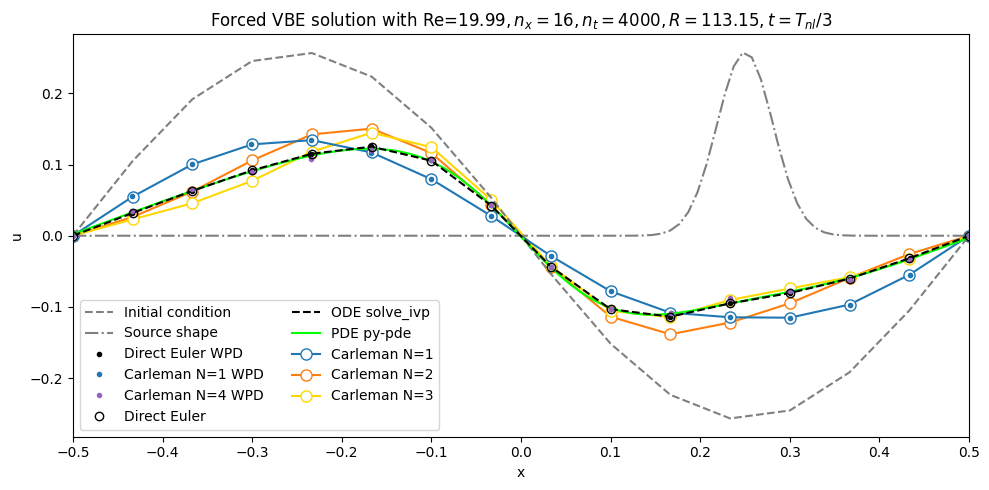

In [166]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Find indices for which we will plot the solution
i_plot = (np.where(ts>=t_plot)[0])[0];
i_plot_pde = (np.where(ts_pde>=t_plot)[0])[0];
i_start = np.ceil(i_plot*3/4);

# Plot Initial condition and solution at third nonlinear time
plt.plot(xs, u0s, '--', label=r'Initial condition', color='gray', zorder=-999);
plt.plot(xs_pde, F0_fun(0,xs_pde), '-.', label=r'Source shape', color='gray', zorder=-999);

# WPD data
f = open('dataWPD/Fig1a/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', color='black', label='Direct Euler WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', color='tab:blue', label='Carleman N=1 WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', color='tab:purple', label='Carleman N=4 WPD')

plt.plot(xs, us_e[i_plot,:],'ko', label=r'Direct Euler', markerfacecolor='none');
plt.plot(xs, us_d[:,i_plot],'k--', label=r'ODE solve_ivp', zorder=-99);
plt.plot(xs_pde, us_pde[i_plot_pde,:], color='lime', label=r'PDE py-pde', zorder=-999)

N=1; plt.plot(xs, np.reshape(ys_c_N[N-1,i_plot,0:nx], (nx)) ,'o-', color='tab:blue', markersize=8, markerfacecolor='white', label=r'Carleman N={}'.format(N), zorder=-9999)
N=2; plt.plot(xs, np.reshape(ys_c_N[N-1,i_plot,0:nx], (nx)) ,'o-', color='tab:orange', markersize=8, markerfacecolor='white', label=r'Carleman N={}'.format(N), zorder=-999999)
N=3; plt.plot(xs, np.reshape(ys_c_N[N-1,i_plot,0:nx], (nx)) ,'o-', color='gold', markersize=8, markerfacecolor='white', label=r'Carleman N={}'.format(N), zorder=-99999)

plt.legend(ncol=2)
Re_act = np.max(np.max(us_pde))*L0/nu;
plt.title(r'Forced VBE solution with Re='+'${:.2f}, n_x={}, n_t={}, R={:.2f}$'.format(Re_act, nx, nt, R)+'$, t=T_{nl}/3$' )

plt.xlabel(r'x')
plt.ylabel(r'u')
plt.xlim([-0.5,+0.5])
plt.xticks(np.arange(-0.5,0.51,0.1))
plt.tight_layout()
plt.show()

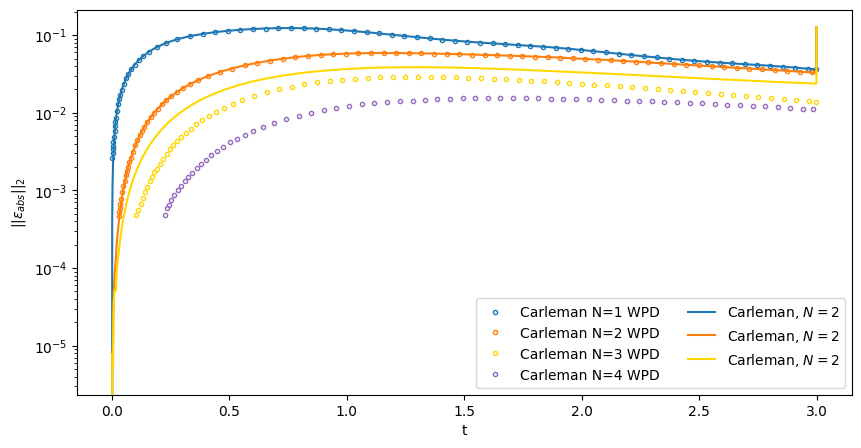

In [164]:
# fig1b Error of each Carleman approach
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

f = open('dataWPD/Fig1b/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markerfacecolor='none', color='tab:blue', label='Carleman N=1 WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markerfacecolor='none', color='tab:orange', label='Carleman N=2 WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markerfacecolor='none', color='gold', label='Carleman N=3 WPD')
# 
datatmp = data['datasetColl'][3]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markerfacecolor='none', color='tab:purple', label='Carleman N=4 WPD')

N=1; plt.plot(ts,eps_c_d_N[N-1,:], color='tab:blue', label=r'Carleman, $N={}$'.format(N1) );
N=2; plt.plot(ts,eps_c_d_N[N-1,:], color='tab:orange', label=r'Carleman, $N={}$'.format(N1) );
N=3; plt.plot(ts,eps_c_d_N[N-1,:], color='gold', label=r'Carleman, $N={}$'.format(N1) );
    
plt.legend(ncol=2)
plt.xlabel(r't')
plt.ylabel(r'$||\epsilon_{abs}||_2$')
plt.yscale('log')
plt.show()

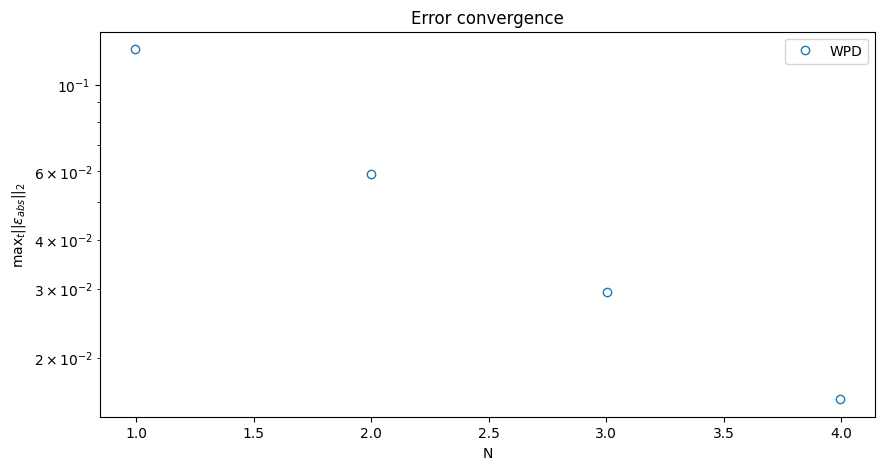

In [167]:
# fig1c
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

f = open('dataWPD/Fig1c/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', markerfacecolor='none', color='tab:blue', label='WPD')
# Plot time-maximum absolute l_2 error between Carleman and pdepe
#plt.semilogy(Ns, max(eps_c_d_N,[],2),'-o','DisplayName',sprintf('Time-maximum error'));
#
plt.legend()
plt.xlabel(r'N')
plt.ylabel(r'$\mathrm{max}_t ||\epsilon_{abs}||_2$')
plt.title(r'Error convergence')
plt.yscale('log')
plt.show()